<a href="https://colab.research.google.com/github/katerinakazantseva/scientific_python/blob/master/HW3_ITMO_Averagine%2C_english_peptides_and_de_novo_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Hi everybody!###

Today we will get the definition and coefficients of the averaged amino acid - Avergine, Avg (yes, this is a stupid joke) -, build a dictionary of English words from the amino acid alphabet, simulate MS2 spectra for them and make a very simple *de novo* algorithm for identifying MS2.

[Link](https://forms.gle/wGAUXcJ9E4D7uVDF6) to the google.form for answering questions.

The program code is located here.

Maximum grade: 20 scores

I suggest that we first enter all the libraries and tables necessary for the entire job  

In [1]:
import collections
import random
import re
import os
import sys
import gzip
import urllib.request

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Compared to the previous task, the aa2formula table has undergone two changes


*   In addition to the standard cysteine, I added 'C(ca)' - ([Cysteine Carbamidomethylation](https://www.sigmaaldrich.com/technical-documents/articles/biology/peptide-modifications-n-terminal-internal-and-c-terminal.html#cysteine-carbamidomethylation)). The fact is that cysteine forms intraprotein sulfide bridges and, in order to destroy existing ones and prevent the formation of new bridges, during the preparation of samples, experimenters add a reagent that reacts with cysteine, which leads to its modification. It is assumed that the efficiency of this reaction is 100%, therefore this modification is called fixed (fixed modification)
![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/77/Iodoacetamide_mech_wiki.png/1024px-Iodoacetamide_mech_wiki.png)
*  'M(ox)' - oxidation reaction of methionine. Unlike the previous modification, oxidation is a rather variable modification (that is, not all methionines that we find in proteomics are modified), which may have a [biological regulatory significance]((https://www.liebertpub.com/doi/abs/10.1089/152308603770310239)) or may be introduced during sample preparation.

![](https://www.ionsource.com/Card/MetOx/metox.1.gif)

In [2]:
aa2formula = {
    'A': {'C': 3, 'H': 7, 'N': 1, 'O': 2},
    'R': {'C': 6, 'H': 14, 'N': 4, 'O': 2},
    'N': {'C': 4, 'H': 8, 'N': 2, 'O': 3},
    'D': {'C': 4, 'H': 7, 'N': 1, 'O': 4},
    'C': {'C': 3, 'H': 7, 'N': 1, 'O': 2, 'S': 1},
    'C(ca)': {'C': 5, 'H': 10, 'N': 2, 'O': 3, 'S': 1},
    'Q': {'C': 5, 'H': 10, 'N': 2, 'O': 3},
    'E': {'C': 5, 'H': 9, 'N': 1, 'O': 4},
    'G': {'C': 2, 'H': 5, 'N': 1, 'O': 2},
    'H': {'C': 6, 'H': 9, 'N': 3, 'O': 2},
    'I': {'C': 6, 'H': 13, 'N': 1, 'O': 2},
    'L': {'C': 6, 'H': 13, 'N': 1, 'O': 2},
    'K': {'C': 6, 'H': 14, 'N': 2, 'O': 2},
    'M': {'C': 5, 'H': 11, 'N': 1, 'O': 2, 'S': 1},
    'M(ox)': {'C': 5, 'H': 11, 'N': 1, 'O': 3, 'S': 1},
    'F': {'C': 9, 'H': 11, 'N': 1, 'O': 2},
    'P': {'C': 5, 'H': 9, 'N': 1, 'O': 2},
    'S': {'C': 3, 'H': 7, 'N': 1, 'O': 3},
    'T': {'C': 4, 'H': 9, 'N': 1, 'O': 3},
    'W': {'C': 11, 'H': 12, 'N': 2, 'O': 2},
    'Y': {'C': 9, 'H': 11, 'N': 1, 'O': 3},
    'V': {'C': 5, 'H': 11, 'N': 1, 'O': 2},
}

In this task, we will ignore the existence of isotopes and will use monoisotopic masses, but you must always keep in mind that usually a few isotopes of the same peptide get into fragmentation. So fragments do form isotopic patterns similar to those that we simulated for MS1, but now on MS2 level.

In [3]:
atom2mass = {
    'C': 12.0,
    'H': 1.00782503223,
    'O': 15.99491461956,
    'N': 14.00307400486,
    'S': 31.97207100
}



---



**Part 1. Averagine**

Averagine is an abstract amino acid averaged over the occurrence of amino acids and atomic content. The concept itself was first formulated [in this article](https://link.springer.com/article/10.1016/1044-0305(95)00017-8). Using the protein sequence database [PIR](https://proteininformationresource.org/pirwww/about/), all amino acid sequences of all organisms available at that time (1995), the authors found the atomic formula of the Averagine molecule
* C 4.9384
* H 7.7583
* N 1.3577
* O 1.4773
* S 0.0417

and a mass of 111.1254 Da.

The Averagine abstraction is very useful for many steps in the proteomics data analysis. 

Download the fasta file with the proteome of the organism of interest from [uniprot](https://www.uniprot.org/proteomes/).

In [10]:
def read_fasta(uniprot_id, kingdom="Eukaryota"):
    filename = "{}.fasta".format(uniprot_id)
    if not os.path.exists(filename):
        urllib.request.urlretrieve(
            "ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/{}/{}.fasta.gz".format(kingdom, uniprot_id),
            filename)
    seq = ""
    nam = ""
    records = {}
    with open(filename, 'rt') as fs:
        for line in fs:
            if line[0] == '>':
                if nam != "":
                    records[nam] = seq
                nam = line.split()[0][1:]
                seq = ""
            else:
                seq += line.rstrip()
        # TODO I guess, we may forget something
    return records

*UP000005640_9606* is the uniprot_id of the human proteome. How I found this match? I did a search on the site [uniprot](https://www.uniprot.org/proteomes/), but it was also possible to use the [REST API](https://www.uniprot.org/help/programmatic_access ).

In [43]:
human_records = read_fasta("UP000005640_9606")
human_records['sp|Q14003|KCNC3_HUMAN']

'MLSSVCVSSFRGRQGASKQQPAPPPQPPESPPPPPLPPQQQQPAQPGPAASPAGPPAPRGPGDRRAEPCPGLPAAAMGRHGGGGGDSGKIVINVGGVRHETYRSTLRTLPGTRLAGLTEPEAAARFDYDPGADEFFFDRHPGVFAYVLNYYRTGKLHCPADVCGPLFEEELGFWGIDETDVEACCWMTYRQHRDAEEALDSFEAPDPAGAANAANAAGAHDGGLDDEAGAGGGGLDGAGGELKRLCFQDAGGGAGGPPGGAGGAGGTWWRRWQPRVWALFEDPYSSRAARYVAFASLFFILISITTFCLETHEGFIHISNKTVTQASPIPGAPPENITNVEVETEPFLTYVEGVCVVWFTFEFLMRITFCPDKVEFLKSSLNIIDCVAILPFYLEVGLSGLSSKAAKDVLGFLRVVRFVRILRIFKLTRHFVGLRVLGHTLRASTNEFLLLIIFLALGVLIFATMIYYAERIGADPDDILGSNHTYFKNIPIGFWWAVVTMTTLGYGDMYPKTWSGMLVGALCALAGVLTIAMPVPVIVNNFGMYYSLAMAKQKLPKKKNKHIPRPPQPGSPNYCKPDPPPPPPPHPHHGSGGISPPPPITPPSMGVTVAGAYPAGPHTHPGLLRGGAGGLGIMGLPPLPAPGEPCPLAQEEVIEINRADPRPNGDPAAAALAHEDCPAIDQPAMSPEDKSPITPGSRGRYSRDRACFLLTDYAPSPDGSIRKATGAPPLPPQDWRKPGPPSFLPDLNANAAAWISP'

Let's write a function that finds the frequency of amino acids occurrences by a set of amino acid sequences and finds the Averagine coefficients as the mathematical expectation.

In [101]:
def get_averagine(fasta_records):
    aa2count = {k: 0 for k, v in aa2formula.items()}
    for k, v in fasta_records.items():
        for aa in v:
            if aa in aa2count:
                aa2count[aa]=aa2count[aa]+1
                
    aa_count_sum = sum(aa2count.values())
    atom2count = {'C': 0, 'H': 0, 'N': 0, 'O': 0, 'S': 0}
    for aa, aa_count in aa2count.items():
        prob = aa_count / aa_count_sum
       
        for atom, atom_count in aa2formula[aa].items():
            atom2count[atom] += atom_count*prob
        atom2count['H'] = atom2count['H']-2*prob
        atom2count['O'] = atom2count['O']-prob
    return atom2count

Drum Roll - let's find Averagine for Human.

And they turned out to be quite close to the values from this [article](https://link.springer.com/article/10.1016/1044-0305(95)00017-8), I hope.

In [102]:
human_aa_avg = get_averagine(human_records)
print('\n'.join(["{}\t{}".format(a, round(count, 3)) for a, count in human_aa_avg.items()]))
assert round(human_aa_avg['C'], 3) == 4.921, "Wrong C-coeffiecient of Averagine"
assert round(human_aa_avg['H'], 3) == 7.766, "Wrong H-coeffiecient of Averagine"
assert round(human_aa_avg['N'], 3) == 1.375, "Wrong N-coeffiecient of Averagine"
assert round(human_aa_avg['O'], 3) == 1.484, "Wrong O-coeffiecient of Averagine"
assert round(human_aa_avg['S'], 3) == 0.044, "Wrong S-coeffiecient of Averagine"
avg_mass = sum([atom2mass[k]*v for k, v in human_aa_avg.items()])
print(round(avg_mass, 3))
assert abs(round(avg_mass, 3) - 111.278) < 0.01, "Wrong human Averagine mass"

C	4.921
H	7.766
N	1.375
O	1.484
S	0.044
111.28


**Question 1** - in the [google.form](https://forms.gle/nTKosK3dUiK2terx9)

In [103]:
td = read_fasta("UP000007648_9305")
td_aa_avg = get_averagine(td)
avg_mass = sum([atom2mass[k]*v for k, v in td_aa_avg.items()])
print(round(avg_mass, 3))

111.738




---



**Part 2. English peptides, MS2 simulation and de novo peptide assembly algorithm**

MADAGASCAR, AMSTERDAM, SCIENCE, PEPTIDE, ... - these are all English words made up of a 20-letter amino acid dictionary. Let's take a large set of English words and filter out those words that can be composed of amino acids?

In [ ]:
def is_peptide(sequence):
    aa_dict = set("ACDEFGHIKLMNPQRSTVWY") # all amino acids
    return not bool(set(sequence).difference(aa_dict))


def load_words(word_file):
    valid_words = []
    with open(word_file) as word_stream:
        for line in word_stream:
            word = line.rstrip().upper()
            if is_peptide(word):
                valid_words.append(word)
    return valid_words

filename = "words_alpha.txt"
location = "https://raw.githubusercontent.com/dwyl/english-words/master/" + filename

if not os.path.exists(filename):
    urllib.request.urlretrieve(location, filename)

english_peptides = load_words(filename)
print(len(english_peptides))

To make these English peptides look more like real ones, we need to do some manipulation on them.

First, let's filter by length - proteomics very poorly detects peptides less than 6 amino acids in length (aa).

In [ ]:
def filer_length(peptides, min_length=6):
    new_peptides = []
    for peptide in peptides:
        if len(peptide) >= min_length:
            new_peptides.append(peptide)
    return new_peptides

Unfortunately, we will not be able to work with the SCIENCE peptide, because it does not have lysine or arginine at the C-terminus (blue). But we can simply add arginine to all English peptides, then not SCIENCE, but SCIENCER, that is, a person who does science.

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Tetrapeptide_structural_formulae_v.1.png/1920px-Tetrapeptide_structural_formulae_v.1.png)

In [ ]:
def add_arginine(peptides):
    new_peptides = []
    for peptide in peptides:
        new_peptides.append(peptide + 'R')
    return new_peptides

And the last thing - methionine can be oxidized, and in our world this is an absolutely random process. Note that the non-oxidized form always remains among the English peptides.

In [ ]:
def add_methionine_oxydation(peptides, prob=0.1):
    random.seed(12345)
    new_peptides = []
    for peptide in peptides:
        new_peptide = ""
        for aa in peptide:
            if aa == 'M' and random.random() < prob:
                new_peptide += "M(ox)"
            else:
                new_peptide += aa
        if new_peptide != peptide:
            new_peptides.append(new_peptide)
        new_peptides.append(peptide)

    return new_peptides

In [ ]:
mod_english_peptides = add_methionine_oxydation(add_arginine(filer_length(english_peptides)))
print(len(mod_english_peptides))

Plot the length distribution of these English peptides

In [ ]:
length_arr = [len(peptide) for peptide in mod_english_peptides]

plt.title("Length distribution of English peptides")
plt.ylabel("count")
plt.xlabel("length")
plt.hist(length_arr, range(min(length_arr), max(length_arr)), histtype='bar', rwidth=0.8)
plt.show()

Great, but where is proteomics?

![alt text](https://www.meme-arsenal.com/memes/b0e1b7cd6ed3c0b4f98e1b9385ad6b4d.jpg)

Unfortunately, still no one has bothered to chemically synthesize these peptides, although by modern standards this is already quite [a solvable problem](https://www.nature.com/articles/nbt.2585). Therefore, we will use a neural network that predicts the fragment intensities for MS2 from the peptide sequence. The model itself was trained on a lot of proteomic data and shows good results on real [trypsin peptides](https://www.nature.com/articles/s41592-019-0427-6) (which is why we added R to the English peptides) ...

![](https://3.bp.blogspot.com/-4CS6EajXxMM/XOxhWwp0wBI/AAAAAAAAJ7s/hPh5grRWPT0tvFuPpJYPpmh0SF1vrikNgCLcBGAs/s640/example_prediction%2B%25281%2529.jpg)

The neural model itself can be used only on Google Cloud ML, following detailed instructions from [the authors of the article](https://github.com/verilylifesciences/deepmass/tree/master/prism). To do this, you need to save the peptides in a csv file, with four required columns: *ModifiedSequence, Charge, Fragmentation, MassAnalyzer*. 

*ModifiedSequence* are the sequences of the modified English peptide.

Let the charge for all peptides be 2 (*Charge*).

There are many ways to fragment peptides into fragments inside the measuring device - *HCD* and *CID* are, perhaps, the most popular and accessible of them. These two fragmentation methods are very similar - they generate the same y- and b-ions, but with a difference in intensity. In the case of English peptides, we will create two files for both fragmentation methods. As a mass analyzer (*MassAnalyzer*), we will indicate [FTMS](https://en.wikipedia.org/wiki/Fourier-transform_ion_cyclotron_resonance) - Orbitrap is part of this family of mass analyzers. 

In [ ]:
def write_peptides_DeepMass(peptides, output_file, charge=2, fragmentation="CID", mass_analyzer="FTMS"):
    with open(output_file, 'w') as wstream:
        wstream.write("ModifiedSequence,Charge,Fragmentation,MassAnalyzer\n")
        for peptide in peptides:
            wstream.write(','.join([peptide, str(charge), fragmentation, mass_analyzer]) + '\n')

if not os.path.exists("english_peptides.2.cid"):
    os.makedirs("english_peptides.2.cid")
write_peptides_DeepMass(mod_english_peptides, "english_peptides.2.cid/input_table.csv", 2, "CID")
if not os.path.exists("english_peptides.2.hcd"):
    os.makedirs("english_peptides.2.hcd")
write_peptides_DeepMass(mod_english_peptides, "english_peptides.2.hcd/input_table.csv", 2, "HCD")

And then you need to follow the instructions - [pre-processing, prediction, post-processing](https://github.com/verilylifesciences/deepmass/tree/master/prism). All these steps are quite routine and require tedious registration and setup of the [Google Cloud Project](https://cloud.google.com/) and communication with colleagues. Therefore, I suggest to just use the data that I received after completing all these steps.

[Results for CID](https://drive.google.com/open?id=1Gmw7nzzjCP2vYFqbGvJEY1LULHutSwCS) prediction

[Results for HCD](https://drive.google.com/open?id=19U7DCRXH3QdsjwuzgDPjFG0AfxyCNX5v) prediction

Or you can use this code, which downloads the data to the current working folder.

In [ ]:
cid_file = "english_peptides.2.cid.outputs.tsv.gz"
if not os.path.exists(cid_file):
    google_drive_file = urllib.request.urlopen("https://drive.google.com/uc?export=download&id=1Gmw7nzzjCP2vYFqbGvJEY1LULHutSwCS")
    with open(cid_file, 'wb') as out:
        out.write(google_drive_file.read())

hcd_file = "english_peptides.2.hcd.outputs.tsv.gz"
if not os.path.exists(hcd_file):
    google_drive_file = urllib.request.urlopen("https://drive.google.com/uc?export=download&id=19U7DCRXH3QdsjwuzgDPjFG0AfxyCNX5v")
    with open(hcd_file, 'wb') as out:
        out.write(google_drive_file.read())

We slightly modify the functions we made during the last homework to work with modified peptides.

In [ ]:
def get_mol_formula(mod_sequence):
    result = {'C': 0, 'H': 0, 'N': 0, 'O': 0, 'S': 0}
    aas = re.findall(r'(\w(?:\(\w+\))?)', mod_sequence)
    # that regular expression is tricky one
    # "GM(ox)ATSR" will be splitted on  "G" "M(ox)" "A" "C(ca)" "S" "R"
    for aa in aas:
        for key, value in aa2formula[aa].items():
            result[key] += #TODO
    #TODO remove water
    return result


def get_mass_mol_formula(formula):
    m = 0.0
    for atom, cnt in formula.items():
        #TODO
    return m

In [ ]:
formula = get_mol_formula("GM(ox)ATSR")
print(formula)
assert formula['C'] == 23, "Wrong amount of Carbon atoms"
assert formula['O'] == 10, "Wrong amount of Oxygen atoms"
assert formula['S'] == 1, "Wrong amount of Sulfur atoms"
mass = get_mass_mol_formula(formula)
assert abs(round(mass, 3) - 637.285) < 0.01, "Wrong mass"

We will keep DeepMass predictions in several classes. This will allow us to quickly scale up our solution.

Let's create a class for one fragment from MS2.

In [ ]:
class Fragment:
    """
    Fragment class holds information about one fragment in MS2 spectrum
    """

    def __init__(self, mz, intensity, ion_type, position):
        """
        :param mz: mass to charge ratio of the fragment
        :param intensity: intensity of the fragment
        :param ion_type: 'y' or 'b' ions, and '!' for noise-fragment
        :param position: fragment position within a peptide sequence, -1 for noise-fragments
        """
        self.mz = mz
        self.intensity = intensity
        self.ion_type = ion_type
        self.position = position

And one more class for the whole spectrum, the aggregate of fragments.

The *add_noise* function will allow you to add random fragments that will simulate noise: in reality, it can be a co-fragmentation peptide or just technical noise from a mass analyzer.

The *plot* function will allow you to visualize the spectrum of interest.

In [ ]:
class Spectrum:
    """
    Spectrum class holds peptide sequence information and information about fragments
    """

    def __init__(self, mod_sequence, fragments):
        """
        :param mod_sequence: peptide sequence with modifications (like (ox) etc.)
        :param precursor_mz: 1-charges mass of the peptide
        :param fragments: list of Fragment objects - MS2 fragments of certain peptide
        """
        self.mod_sequence = mod_sequence
        self.sequence = re.sub(r'\(\w+\)', '', mod_sequence) # remove modifications
        self.precursor_mz = get_mass_mol_formula(get_mol_formula(mod_sequence))
        self.mod_aas = re.findall(r'(\w(?:\(\w+\))?)', mod_sequence) # the same reg.exp as in get_mol_formula    
        self.fragments = sorted(fragments, key=lambda x: x.mz)
        
    def add_noise(self, noise_factor=2, percentile=0.3):
        """Add noise to the data - make it more real
        :param noise_factor: - how many noise fragments to create? - noise_factor*<number of non-0 fragments>
        :param percentile:
        :return: will return a new Spectrum; Achtung - shallow copy
        """
        intensities = [f.intensity for f in self.fragments if f.intensity != 0.0]
        new_fragments = [f for f in self.fragments]
        cnt_noise_fragments = int(noise_factor * len(intensities))

        # to make noise reproducible and different from sequence to sequence
        np.random.seed(abs(hash(self.mod_sequence)) % (2 ** 32))
        noise_max_intensity = np.percentile(intensities, percentile * 100)
        noise_intensities = np.random.uniform(0, noise_max_intensity, cnt_noise_fragments)
        noise_mzs = np.random.uniform(0, max([f.mz for f in self.fragments]) + 150, cnt_noise_fragments)
        for i in range(cnt_noise_fragments):
            new_fragments.append(Fragment(noise_mzs[i], abs(noise_intensities[i]), '!', -1))
        # I am only commenting out this `return` so that you pay attention to the implementation details of this add_noise function.
        # Try to understand what is going on here, it will be important further
        # return Spectrum(self.mod_sequence, new_fragments)
        return None

    def plot(self):
        """
        :return: none
        """
        fig = plt.figure(constrained_layout=True)
        gs = fig.add_gridspec(ncols=5, nrows=10)
        xmin = 0
        xmax = max([f.mz for f in self.fragments]) + 150

        ax0 = fig.add_subplot(gs[0, :])
        ax0.text(0.0, 0.0, self.mod_sequence, fontsize=12)
        ax0.axis('off')

        ax1 = fig.add_subplot(gs[1, :])
        ax1.vlines(x=[f.mz for f in self.fragments if f.intensity != 0.0 and f.ion_type == "b"],
                   ymin=0,
                   ymax=[1 for f in self.fragments if f.intensity != 0.0 and f.ion_type == "b"],
                   colors="red",
                   alpha=0.4)
        ax1.vlines(x=[f.mz for f in self.fragments if f.intensity == 0.0 and f.ion_type == "b"],
                   ymin=0,
                   ymax=[1 for f in self.fragments if f.intensity == 0.0 and f.ion_type == "b"],
                   linestyles="dotted",
                   colors="red",
                   alpha=0.4)
        bmass = [f.mz for f in self.fragments if f.ion_type == "b"] + [xmin, xmax]
        bmass.sort()
        for f in self.fragments:
            if f.ion_type == "b":
                xpos = (bmass[f.position] - bmass[f.position - 1]) / 2 + bmass[f.position - 1]
                ax1.annotate(self.mod_aas[f.position - 1], (xpos, 0.5), fontsize=8, ha='center')
        ax1.axes.get_xaxis().set_visible(False)
        ax1.axes.get_yaxis().set_ticks([])
        ax1.set_ylabel("prefix\n(b-ions)", fontsize=8)
        ax1.set_xlim([xmin, xmax])

        ax2 = fig.add_subplot(gs[2, :])
        ax2.vlines(x=[f.mz for f in self.fragments if f.intensity != 0.0 and f.ion_type == "y"],
                   ymin=0,
                   ymax=[1 for f in self.fragments if f.intensity != 0.0 and f.ion_type == "y"],
                   colors="blue",
                   alpha=0.4)
        ax2.vlines(x=[f.mz for f in self.fragments if f.intensity == 0.0 and f.ion_type == "y"],
                   ymin=0,
                   ymax=[1 for f in self.fragments if f.intensity == 0.0 and f.ion_type == "y"],
                   linestyles="dotted",
                   colors="blue",
                   alpha=0.4)
        ymass = [f.mz for f in self.fragments if f.ion_type == "y"] + [xmin, xmax]
        ymass.sort()
        for f in self.fragments:
            if f.ion_type == "y":
                xpos = (ymass[f.position] - ymass[f.position - 1]) / 2 + ymass[f.position - 1]
                ax2.annotate(self.mod_aas[len(self.sequence) - f.position], (xpos, 0.5), fontsize=8, ha='center')
        ax2.axes.get_xaxis().set_visible(False)
        ax2.axes.get_yaxis().set_ticks([])
        ax2.set_ylabel("suffix\n(y-ions)", fontsize=8)
        ax2.set_xlim([xmin, xmax])

        ax3 = fig.add_subplot(gs[3:, :])
        colors = []
        for f in self.fragments:
            if f.intensity != 0.0:
                if f.ion_type == 'y':
                    colors.append('blue')
                elif f.ion_type == 'b':
                    colors.append('red')
                else:
                    colors.append('grey')
        ax3.vlines(x=[f.mz for f in self.fragments if f.intensity != 0.0],
                   ymin=0,
                   ymax=[f.intensity for f in self.fragments if f.intensity != 0.0],
                   color=colors,
                   alpha=0.4)
        for f in self.fragments:
            if f.intensity != 0.0:
                if f.ion_type == 'y':
                    ax3.annotate(round(f.mz, 2), (f.mz, f.intensity), fontsize=8, ha='center', color="blue")
                elif f.ion_type == 'b':
                    ax3.annotate(round(f.mz, 2), (f.mz, f.intensity), fontsize=8, ha='center', color="red")
        ax3.set_xlim([xmin, xmax])

        plt.show()

Perhaps now is the best time to talk about the value of the *ion_type* variable in the *Fragment* class, which can take the values ​​'y' or 'b' for [CID/HCD fragmentation](https://support.proteomesoftware.com/hc/en-us/articles/115000616243-CID-ETD-HCD-and-Other-Fragmentation-Modes-in-Scaffold).

Consider the peptide GLSDGEWQQVLNVWGK. After fragmentation for this peptide, we can see the following prefixes

![](http://ionsource.com/tutorial/DeNovo/art/b_ions_arrows.gif)

and suffixes

![](http://ionsource.com/tutorial/DeNovo/art/y_ions_arrows.gif).

However, the peptide bond itself can be broken in different ways, and the community has agreed on certain names for the corresponding fragments - a/x, b/y, c/z.
![](https://upload.wikimedia.org/wikipedia/commons/f/fb/Peptide_fragmentation.gif)

HCD/CID fragmentation methods generate exclusively b/y ions.

Now you can read the results from DeepMass.

A few notes on this code


1. From the previous steps, you can see that we only write the M(ox) modification to the DeepMass input file, but not C(ca). And the reason is that DeepMass trained on data in which cysteine ​​was always modified (we said it was fixed modification) and the model always perceives C as a modified version of cysteine. However, when reading the output, I would like to suggest replacing C with C(ca) to avoid any confusion later on.
2. It turns out that DeepMass, in the output, shows fragments of y- and b-ions, consisting of all the amino acids of the peptide (full length peptide), and indicates their intensity as zero. Indeed, such ions are usually not visible in the spectrum at all due to the high fragmentation efficiency. But for the sake of simplicity of the subsequent de novo algorithm, I replaced the zero intensities of these fragments with the minimum non-zero predicted intensity in the entire spectrum. From another point of view, we can get this mass from the first MS, so non-zero value for those ions is a pretty justified step.

In [ ]:
def read_deepmass_output(gz_file, max=sys.maxsize):
    """ Read output data from DeepMass
    :param gz_file: 
    :param max: maximum spectrum to read
    :return: dictionary peptide_sequence -> spectrum
    """
    peptide2spectrum = {}
    with gzip.open(gz_file, 'rt') as stream:
        header = stream.readline().rstrip().split('\t')
        modseq_ind = header.index("ModifiedSequence")
        fragments_intensity_ind = header.index("FragmentIntensities")
        fragments_ions_ind = header.index("FragmentIons")
        fragments_mz_ind = header.index("FragmentMZs")
        n = 0
        for line in stream:
            n += 1
            if n > max:
                break
            splt = line.rstrip().split('\t')
            peptide2spectrum[splt[modseq_ind]] = \
                Spectrum(
                    splt[modseq_ind].replace("C", "C(ca)"), # note1
                    [Fragment(float(mz), float(intensity), ion_types[0], int(ion_types.split('_')[0][1:]))
                     for mz, intensity, ion_types in zip(splt[fragments_mz_ind].split(';'),
                                                         splt[fragments_intensity_ind].split(';'),
                                                         splt[fragments_ions_ind].split(';'))
                     ]
                )
            # note2
            bfragments = sorted([f for f in peptide2spectrum[splt[modseq_ind]].fragments if f.ion_type == 'b'],
                                key=lambda x: x.mz)
            bfragments[-1].intensity = min([f.intensity for f in bfragments if f.intensity != 0])
            yfragments = sorted([f for f in peptide2spectrum[splt[modseq_ind]].fragments if f.ion_type == 'y'],
                                key=lambda x: x.mz)
            yfragments[-1].intensity = min([f.intensity for f in yfragments if f.intensity != 0])

    return peptide2spectrum

Now to the point - let's read the results for the CID fragmentation.

In [ ]:
cid = read_deepmass_output("english_peptides.2.cid.outputs.tsv.gz")
hcd = read_deepmass_output("english_peptides.2.hcd.outputs.tsv.gz")

Consider the peptide "AMSTERDAMERR".

In [ ]:
cid['AMSTERDAMERR'].plot()

The topmost graph shows all the possible prefixes for a given peptide. Lines are of two types: a dashed line - DeepMass predicted an intensity of 0 for this fragment - and a solid line - DeepMass predicted a non-zero intensity. That is, a graph of all kinds of prefixes.

The graph below is all kinds of suffixes, otherwise y-ions.

And the last graph shows the spectrum of the peptide with intensity along the OY axis.

In [ ]:
cid['AMSTERDAM(ox)ERR'].plot()

**Question 2** - in the [google.form](https://forms.gle/nTKosK3dUiK2terx9)

And here's an interesting question - how much does the *AMSTERDAMERR* spectrum obtained using CID fragmentation differ from the spectrum obtained using HCD?

As we can see, the spectra are very similar - the most high-intensity fragments appear in one and the other cases.

In [ ]:
hcd['AMSTERDAMERR'].plot()

Such spectra are rather idealized, because there is noticeable noise in the experimental spectrum.

Let's try to add noise to the *AMSTERDAMERR* spectrum. The *noise_factor* parameter affects the number of noisy fragments, and *percentile* - the intensity of such fragments.

In [ ]:
noisy_spectrum = cid['AMSTERDAMERR'].add_noise(noise_factor=10, percentile=0.5)
noisy_spectrum.plot()



---



**Part 3. De novo algorithm**

The task of identifying MS2 is to decipher the unlabeled spectrum, so we need to find which particular peptide could generate such a spectrum.
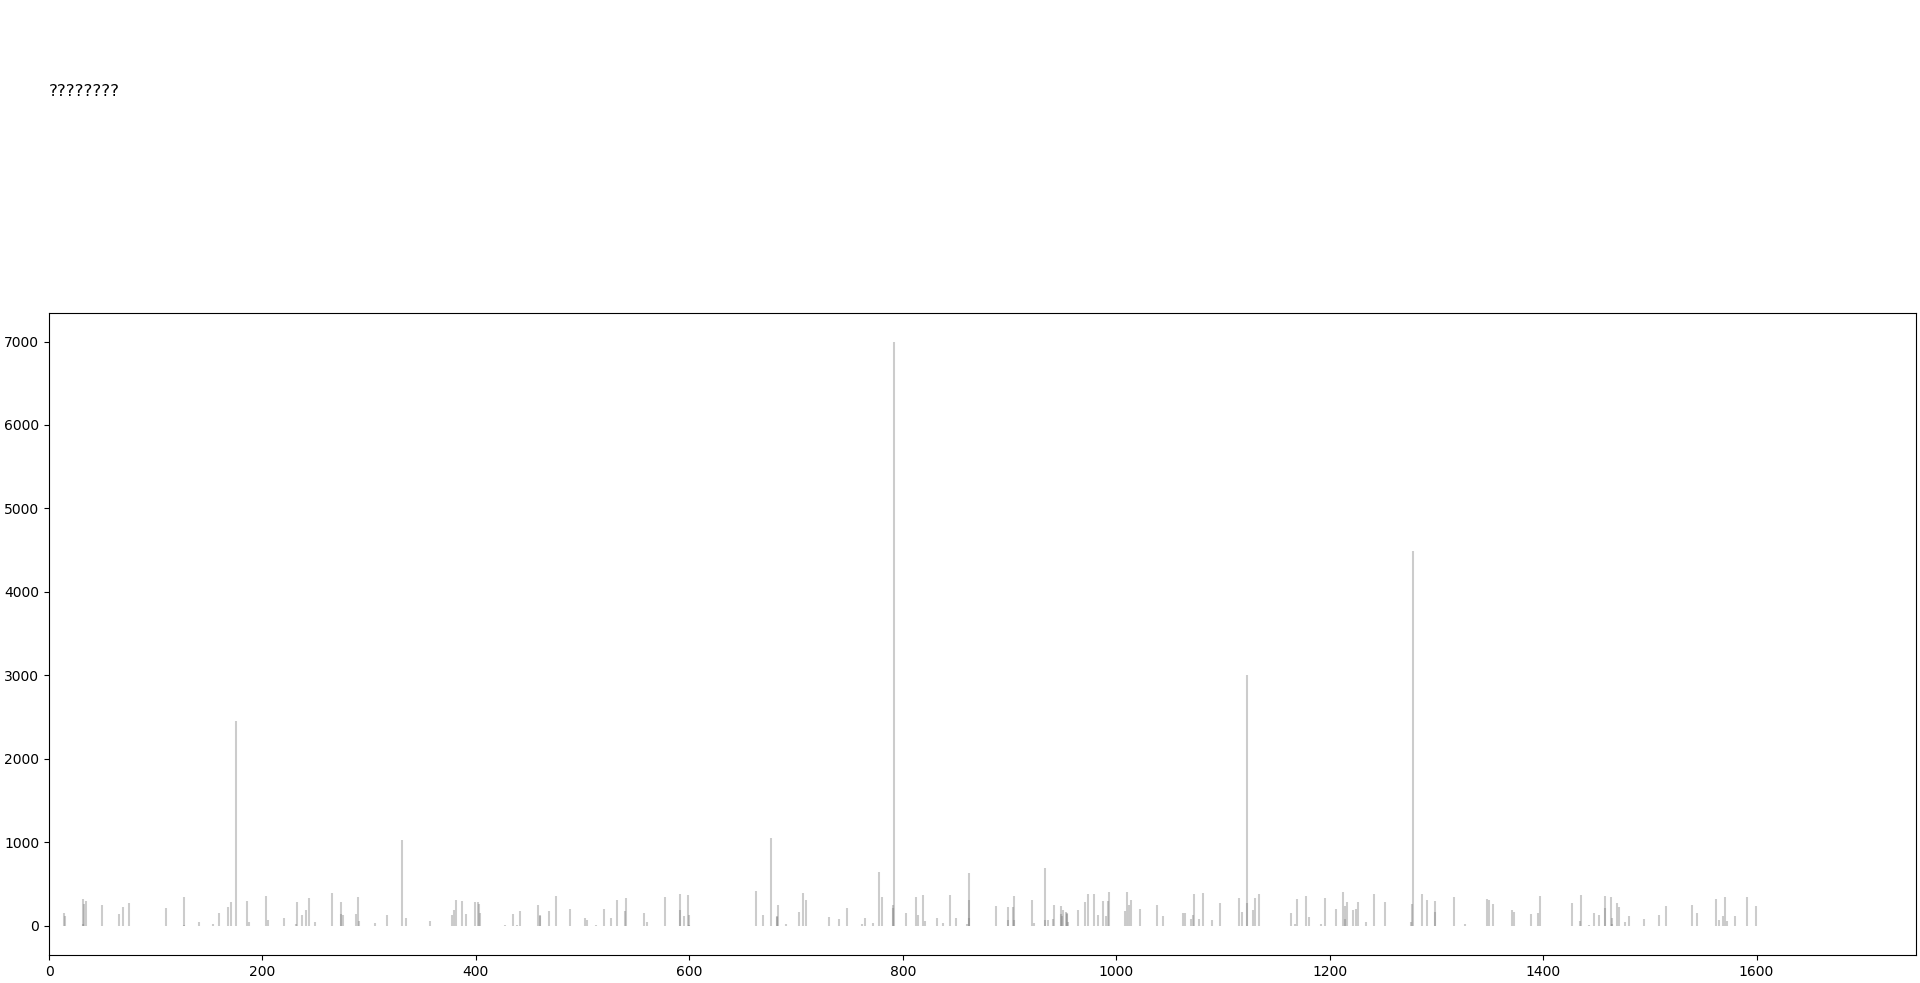


There are two ways to solve this problem.


* de novo peptide assembly algorithm - we only know the masses of amino acids and try to find the sequence of the original peptide using them
* search in the reference database - we know the reference proteome of the investigated object, create a database of theoretical spectra (human cell line etc.), and for each experimental spectrum we try to find the most similar theoretical reference spectrum.

An obvious analogy from the NGS world, and this parallel is not accidental. Continuing the analogy, the more common naming of bottom-up proteomics (we cut proteins into peptides and analyze them) is [shotgun proteomics](https://en.wikipedia.org/wiki/Shotgun_proteomics).

In L4 we are going to discuss the second method, but now - *de novo*.

Let's create several auxiliary dictionaries and functions that will allow us to quickly find the masses of fragments.

In [ ]:
aa2mass = {aa: (get_mass_mol_formula(formula) - 2 * atom2mass['H'] - atom2mass['O']) for aa, formula in
           aa2formula.items()}
aa_yions_terminal2mass = {aa: (mass + 3 * atom2mass['H'] + atom2mass['O']) for aa, mass in aa2mass.items()}
aa_bions_terminal2mass = {aa: (mass + atom2mass['H']) for aa, mass in aa2mass.items()}


def get_masses_yb_ions(mod_sequence):
    mod_aas = re.findall(r'(\w(?:\(\w+\))?)', mod_sequence)
    y_ions = [aa_yions_terminal2mass[mod_aas[len(mod_aas) - 1]]]
    for i in reversed(range(0, len(mod_aas) - 1)):
        y_ions.append(y_ions[len(y_ions) - 1] + aa2mass[mod_aas[i]])
    b_ions = [aa_bions_terminal2mass[mod_aas[0]]]
    for i in range(1, len(mod_aas)):
        b_ions.append(b_ions[i - 1] + aa2mass[mod_aas[i]])
    return y_ions, b_ions

Let's check that we are correctly finding y- and b-ions for the peptide [GLSDGEWQQVLNVWGK](http://db.systemsbiology.net:8080/proteomicsToolkit/FragIonServlet?sequence=GLSDGEWQQVLNVWGK&massType=monoRB&charge=1&bCB=1&yCB=1&nterm=0.0&cterm=0.0&addModifType=&addModifVal=)

In [ ]:
y_ions, b_ions = get_masses_yb_ions("GLSDGEWQQVLNVWGK")
y_exp_ions, b_exp_ions = \
    [147.113, 204.135, 390.214, 489.283, 603.325, 716.41, 815.478, 943.537, 1071.595, 1257.674, 1386.717, 1443.738,
     1558.765, 1645.797, 1758.882, 1815.903], \
    [58.029, 171.113, 258.145, 373.172, 430.194, 559.236, 745.316, 873.374, 1001.433, 1100.501, 1213.585, 1327.628,
     1426.697, 1612.776, 1669.797, 1797.892]
assert len(y_ions) == len(b_ions) == len(y_exp_ions) == len(b_exp_ions), "Test get_masses_yb_ions: different length " \
                                                                         "of arrays "
for i in range(len(y_ions)):
    assert round(y_ions[i], 3) == y_exp_ions[i], \
        "Test get_masses_yb_ions: expecting to see another mass for y{}-ion - expect {} but got {}". \
            format(i + 1, y_exp_ions[i], round(y_ions[i], 3))
    assert round(b_ions[i], 3) == b_exp_ions[i], \
        "Test get_masses_yb_ions: expecting to see another mass for b{}-ion - expect {} but got {}". \
            format(i + 1, b_exp_ions[i], round(b_ions[i], 3))

There are many algorithms for solving the de novo MS2 identification problem, but here we will analyze an extremely simple algorithm.

The *de_novo_algo* function receives three parameters as input


* *mzs*: array of masses of fragments
* *intensities*: array of fragment intensities
* *tolerance*: maximum mass difference between the expected peak (mass of the experimental fragment minus the mass of the amino acid) and the experimental peak. A little further, this wording will become clear.

In the first step, we select the most intense fragment, and then we try to find the fragment to the left of this peak (in the region of low masses) so that the difference between them is equal to the mass of some amino acid with an acceptable error (*tolerance*). Then the same process is repeated to the right (into the area of ​​large masses). Finding this and subsequent amino acids is an iterative identification of the spectrum.

In [ ]:
def de_novo_algo_find_match_left(mzs, ind, aa_mass, tolerance):
    exp_mass = mzs[ind] - aa_mass
    j = 1
    while ind - j >= 0 and exp_mass - mzs[ind - j] < tolerance:
        if abs(exp_mass - mzs[ind - j]) < tolerance:
            break
        j += 1
    if ind - j < 0 or exp_mass - mzs[ind - j] >= tolerance:
        return -1
    return ind - j


def de_novo_algo_find_match_right(mzs, ind, aa_mass, tolerance):
    exp_mass = mzs[ind] + aa_mass
    j = 1
    while ind + j < len(mzs) and exp_mass - mzs[ind + j] > -tolerance:
        if : #TODO fix that
            break
        j += 1
    if ind + j >= len(mzs) or exp_mass - mzs[ind + j] <= -tolerance:
        return -1
    return ind + j


def de_novo_algo_impl(mzs, ind, tolerance, find_match_func):
    for aa, mass in aa2mass.items():
        ind_match = find_match_func(mzs, ind, mass, tolerance)
        if ind_match != -1:
            return aa, ind_match
    return '', -1


def de_novo_algo(mzs, intensities, tolerance=0.05):
    """

    :param mzs:
    :param intensities:
    :param tolerance:
    :return: the best fitted peptide sequence for the spectrum
    """
    yb_series = None
    # max intensity fragment is suffix or prefix? - we don't know yet
    ind_max = intensities.index(max(intensities))
    # going to small masses - left
    predicted_sequence = collections.deque([])
    i = ind_max
    while True:
        aa_pred, ind_pred = de_novo_algo_impl(mzs, i, tolerance, de_novo_algo_find_match_left)
        if aa_pred != '':
            predicted_sequence.appendleft(aa_pred)
            i = ind_pred
        else:
            for aa, mass in aa_yions_terminal2mass.items():
                if abs(mzs[i] - mass) < tolerance:
                    predicted_sequence.appendleft(aa)
                    yb_series = 'y'
                    break
            for aa, mass in aa_bions_terminal2mass.items():
                if abs(mzs[i] - mass) < tolerance:
                    predicted_sequence.appendleft(aa)
                    yb_series = 'b'
                    break
            break
    i = ind_max
    while True:
        aa_pred, ind_pred = de_novo_algo_impl(mzs, i, tolerance, de_novo_algo_find_match_right)
        if aa_pred != '':
            predicted_sequence.append(aa_pred)
            i = ind_pred
        else:
            break

    if yb_series == 'y':
        return "".join(reversed(list(predicted_sequence))) #because suffixes should reversed
    elif yb_series == 'b':
        return "".join(list(predicted_sequence))
    return ""

Let's try to run this function using the peptide *AMSTERDAMERR* as an example

In [ ]:
spectrum = cid['AMSTERDAMERR'].add_noise()
spectrum.plot()
mzs = [f.mz for f in spectrum.fragments if f.intensity != 0.0]
intensities = [f.intensity for f in spectrum.fragments if f.intensity != 0.0]
print(de_novo_algo(mzs, intensities, tolerance=0.03))

Not very good at it.

Let's try the peptide *MADDENINGNESSR*

In [ ]:
# TODO

As you can see, this algorithm was able to correctly interpret the spectrum. But the main reason why the algorithm was able to determine the *MADDENINGNESSR* peptide, but not *AMSTERDAMERR*, is that it is critically important for our implementation that all suffixes or prefixes (depending on the type of the maximum in intensity fragment) appear on the spectrum - in the case of *AMSTERDAMERR* there is no elementary prefix *A*, and the maximum peak is precisely the prefix. The *MADDENINGNESSR* peptide has the most intense fragment of the number of suffixes, and in this series all fragments are represented in the spectrum.

**Question 3** - in the [google.form](https://forms.gle/nTKosK3dUiK2terx9)

Let's try to globally evaluate the accuracy of the algorithm for different values of *tolerance* and *noise_factor*. Which means, we modulate the sensitivity of the algorithm and the amount of noise. In other words, we analyze de novo all spectra and compare prediction with expectation. This gives us the percentage of correctly identified spectra.

In [ ]:
tolerance_range = [0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001]
noise_factor_range = [0.0, 0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0, 15.0]

In [ ]:
def get_correctness_matrix(spectrums, tolerance_range, noise_factor_range, add_mz_noise=False, num_subset=1000):
    correctness = np.empty(shape=(len(tolerance_range), len(noise_factor_range)))
    for ind_t in range(len(tolerance_range)):
        for ind_n in range(len(noise_factor_range)):
            correct = 0
            cnt = 0
            for spectrum in random.choices(spectrums, k=num_subset): # to speed it up
                new_spectrum = spectrum.add_noise(noise_factor_range[ind_n])
                mzs = [f.mz for f in new_spectrum.fragments if f.intensity != 0.0]
                intensities = [f.intensity for f in new_spectrum.fragments if f.intensity != 0.0]
                if add_mz_noise:
                    np.random.seed(abs(hash(spectrum.mod_sequence)) % (2 ** 32))
                    mzs = [abs(x + y) for x, y in zip(np.random.normal(0, 0.001, len(mzs)), mzs)]
                result = de_novo_algo(mzs, intensities, tolerance_range[ind_t])
                if result.replace('I', 'L') == spectrum.mod_sequence.replace('I', 'L'):
                    correct += 1
                cnt += 1
            correctness[ind_t, ind_n] = correct / cnt

    return pd.DataFrame(correctness, columns=noise_factor_range, index=tolerance_range)

**Question 4** - in the [google.form](https://forms.gle/nTKosK3dUiK2terx9)

This calculation will take some time - 1-2 minutes.

In [ ]:
correctness_df = get_correctness_matrix(list(cid.values()), tolerance_range, noise_factor_range)

And it remains to render our correctness matrix in the form of a heatmap.

In [ ]:
ax = sns.heatmap(correctness_df, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel("Noise factor")
plt.ylabel("Match tolerance")
plt.show()

But we need to imagine that for real data the peaks of the fragments have a normal distribution, and as a result, we can only find the real mass with some error.

You can simulate this by adding some random normal noise to the masses of the fragments.

In [ ]:
correctness_mz_noise_df = get_correctness_matrix(list(cid.values()), tolerance_range, noise_factor_range, True)

And of course the results will change.

In [ ]:
ax = sns.heatmap(correctness_mz_noise_df, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel("Noise factor")
plt.ylabel("Match tolerance")
plt.show()

**Question 5** - in the [google.form](https://forms.gle/nTKosK3dUiK2terx9)

